In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Float, Integer, String
from sqlalchemy import desc
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [37]:

measurement = Base.classes.measurement
station = Base.classes.station
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [39]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

In [40]:
# Find the most recent date in the data set.

results = session.query(measurement).order_by(desc(measurement.date)).limit(1)
for result in results:
    recent_date= (result.date)
    print(f"Most recent date is {recent_date}")

# date= recent_date.split("-")
# year=date[0]
# month=date[1]
# day=date[2]
# print(f"{year} ,  {month}, {day}")

Most recent date is 2017-08-23


In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twelve_month_old_date =  (datetime.strptime(recent_date, "%Y-%m-%d") -  timedelta(days=365)).strftime("%Y-%m-%d") #relativedelta(years=1) 
print(twelve_month_old_date)


2016-08-23


In [42]:

# Perform a query to retrieve the data and precipitation scores


results = session.query(measurement).filter(measurement.date>=twelve_month_old_date).with_entities(measurement.date,measurement.prcp)
prcp_df=pd.DataFrame(results)
prcp_df.head()


,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [43]:

#Drop empty rows
prcp_df.dropna(inplace=True)
prcp_df["date"]= pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df.set_index(["date"], inplace=True, drop=True)
prcp_df.head()

# * Sort the DataFrame values by `date`.
prcp_df.sort_index()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


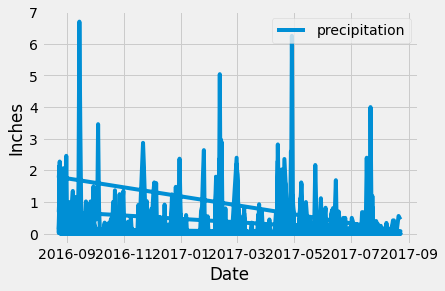

In [45]:

# * Plot the results using the DataFrame `plot` method.
plt.clf()
plt.plot(prcp_df.index,prcp_df["prcp"], label="precipitation")
prcp_df.to_excel("output.xlsx")  
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend( loc ="upper right")
plt.show()


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(prcp_df.describe())

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset
results = session.query(station).count()
print(results)


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query = sqlalchemy.select([
    measurement.station,
    sqlalchemy.func.count( measurement.station)
]).group_by( measurement.station)
result = engine.execute(query).fetchall()
df=pd.DataFrame(result)
df=df.sort_values(by='count_1', ascending=False)
df.reset_index()


In [ ]:
station_with_max_measurements = df.iloc[0,0]

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

query = sqlalchemy.select([measurement.station,
sqlalchemy.func.min( measurement.tobs), 
sqlalchemy.func.max( measurement.tobs), 
sqlalchemy.func.avg( measurement.tobs)]).filter( measurement.station == station_with_max_measurements)
result = engine.execute(query).fetchall()
df=pd.DataFrame(result)
df.head()


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#Find the most recent date for the station is most measurements
query = sqlalchemy.select(measurement).filter( measurement.station == station_with_max_measurements).order_by(desc(measurement.date)).limit(1)
results = engine.execute(query).fetchall()
for result in results:
    recent_date= (result.date)
print(recent_date)
twelve_month_old_date = (datetime.strptime(recent_date, "%Y-%m-%d") - timedelta(days=365)).strftime("%Y-%m-%d")
print(twelve_month_old_date)

In [ ]:
#Create a data frame for last one year of results from station is most readings
results = session.query(measurement.date).filter((
    measurement.station == station_with_max_measurements) & (measurement.date>=twelve_month_old_date)).with_entities(measurement.date,measurement.tobs)
df=pd.DataFrame(results)
#Drop the empty cells if any 
df.dropna(subset=['tobs'], inplace=True)


# Exploratory Precipitation Analysis

In [ ]:
#Draw histogram with 12 bins.
plt.hist(df["tobs"],bins=12, label="tobs")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend( loc ="upper left")
plt.show()


In [ ]:

df.describe()


# Close session

In [ ]:
# Close Session
session.close()